# Chapter 10. 케라스를 사용한 인공 신경망 소개

# 기본 설정

In [1]:
#!pip install tensorflow

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 10.1 생물학적 뉴런에서 인공 뉴런까지

## 10.1.3 퍼셉트론

**퍼셉트론(perceptron)**: 가장 간단한 인공 신경망 구조 중 하나. 입력의 가중치 합을 계산한 뒤, 계산된 합에 **계단 함수(step function)**를 적용하여 결과를 출력하는 **TLU(Threshold Logic Unit)** 하나로 구성됨

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

C:\Users\seculayer\AppData\Local\Temp\ipykernel_8972\1146076147.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


In [4]:
y_pred

array([1])

그림 저장: perceptron_iris_plot


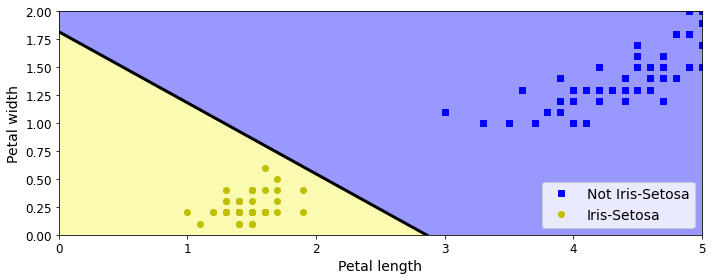

In [5]:
# 퍼셉트론이 붓꽃 데이터를 구분하는 모습을 그래프로 시각화
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
                    np.linspace(axes[2], axes[3], 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y==1, 0], X[y==1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a *axes[1] + b], 'k-', linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)

save_fig('perceptron_iris_plot')
plt.show()

## 10.1.4 다층 퍼셉트론과 역전파(활성화 함수)

**다층 퍼셉트론(MLP)**: **입력층(input layer)** 하나와 **은닉층(hidden layer)**이라 불리는 하나 이상의 TLU층과 마지막 **출력층(output layer)**으로 구성된 구조  

은닉층을 여러 개 쌓아올린 인공 신경망을 **심층 신경망(Deep Neural Network, DNN)**이라고 함

**(중요!!) 역전파(backpropagation)** 알고리즘 작동 방식
1. 각 훈련 샘플에 대해 역전파 알고리즘이 먼저 예측을 만들고(**정방향 계산**) 오차를 측정함
2. 그 다음 역방향으로 각 층을 거치면서 각 연결이 오차에 기여한 정도를 측정함(**역방향 계산**)
3. 마지막으로 이 오차가 감소하도록 가중치를 조정함(**경사 하강법 단계**)

In [6]:
# 필요한 함수를 정의
#시그모이드 함수
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# ReLU 함수
def relu(z):
    return np.maximum(0, z)

# 도함수
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

그림 저장: activation_functions_plot


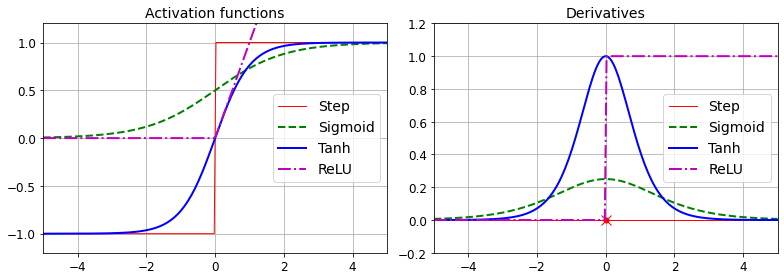

In [7]:
# 활성화 함수와 그들의 도함수를 그래프로 시각화
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Activation functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, 'ro', markersize=5)
plt.plot(0, 0, 'rx', markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, derivative(np.tanh, z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, derivative(relu, z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig('activation_functions_plot')
plt.show()

In [8]:
# 헤비사이드 계단 함수 및 XOR 분류 함수 정의
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

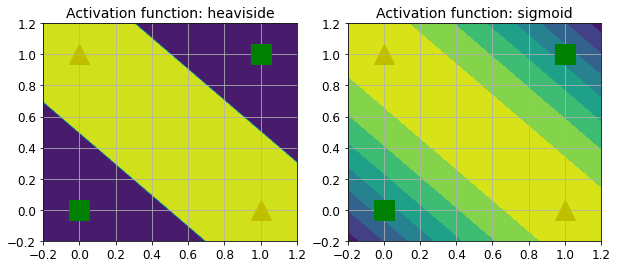

In [9]:
# 그림 10-6에서 봤던 XOR 문제를 계단 함수와 시그모이드 함수로 풀었을 때의 그래프 시각화
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: sigmoid', fontsize=14)
plt.grid(True)

# 10.2 케라스로 다층 퍼셉트론 구현하기

## 10.2.1 텐서플로2 설치

In [10]:
#!pip install tensorflow-gpu

In [2]:
# 텐서플로랑 케라스 임포트
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.10.0'

In [4]:
keras.__version__

'2.10.0'

## 10.2.2 시퀀셜 API를 사용하여 이미지 분류기 만들기

먼저 **패션 MNIST** 데이터셋을 케라스를 사용하여 적재

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

훈련 세트는 60,000개의 흑백 이미지임. 각 이미지의 크기는 28x28 픽셀:

In [15]:
X_train_full.shape

(60000, 28, 28)

각 픽셀의 강도는 byte(0~255)로 표현됨:

In [16]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 조금 더 작은 훈련 세트와 검증 세트로 분리  
또한 픽셀 강도를 255로 나누어 0~1 사이의 실수값으로 변경

In [6]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

matplotlib의 `imshow()` 함수와 `binary` 컬러맵을 사용해 이미지를 출력할 수 있음

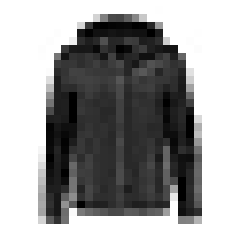

In [18]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

레이블은 0에서 9까지(uint8로 표현된) 클래스 아이디임:

In [19]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

패션 MNIST는 레이블에 해당하는 아이템을 나타내기 위해 클래스 이름의 리스트를 만들어야 함:

In [7]:
class_names = ['T-Shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
              'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

훈련 세트에 있는 첫 번째 이미지는 코드임:

In [21]:
class_names[y_train[0]]

'Coat'

검증 세트는 5,000개의 이미지를 담고 있고, 테스트 세트는 10,000개의 이미지를 가짐:

In [22]:
X_valid.shape

(5000, 28, 28)

In [23]:
X_test.shape

(10000, 28, 28)

그림 저장: fashion_mnist_plot


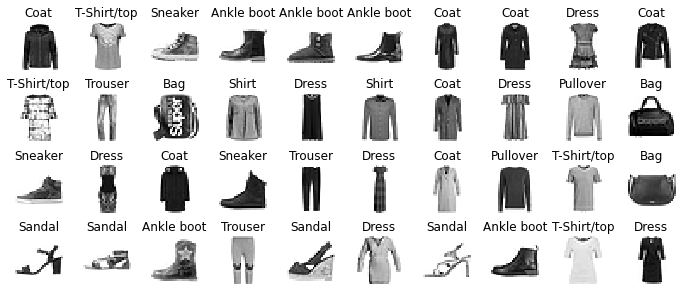

In [24]:
# 데이터셋에 있는 샘플 이미지를 몇 개 출력
n_rows=4
n_cols=10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

### **시퀀셜 API**를 사용하여 모델 만들기  
다음은 두 개의 은닉층으로 이루어진 분류용 다층 퍼셉트론임:

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

위와 같이 층을 하나씩 추가하지 않고 Sequential 모델을 만들 때 층의 리스트를 전달할 수도 있음

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

모델의 `summary()` 메서드는 모델에 있는 모든 층을 출력함:

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [33]:
#!pip install pydot

In [34]:
#!pip install graphviz

In [35]:
# 위 모델을 그림으로 시각화
keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


모델에 있는 층의 리스트를 출력하거나 인덱스로 층을 쉽게 선택할 수 있음  
또는 이름으로 층을 선택할 수도 있음:

In [36]:
model.layers

In [37]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [38]:
model.get_layer(hidden1.name) is hidden1

True

층의 모든 파라미터는 `get_weights()` 메서드와 `set_weights()` 메서드를 사용해 접근할 수 있음  
Dense 층의 경우 연결 가중치의 편향이 모두 포함되어 있음:

In [39]:
weights, biases = hidden1.get_weights()

In [40]:
weights

array([[ 0.03596357,  0.0090813 , -0.05326039, ...,  0.05163859,
         0.04962619, -0.04782479],
       [-0.04634107, -0.04569608,  0.01641158, ..., -0.04903741,
        -0.03455919, -0.049417  ],
       [-0.02363026, -0.0718113 ,  0.05382711, ..., -0.05065654,
         0.00688522,  0.02298707],
       ...,
       [ 0.06120896, -0.010138  ,  0.03359209, ..., -0.01719974,
        -0.00731788, -0.05787557],
       [-0.01262816, -0.06051863,  0.02250861, ...,  0.01391006,
        -0.00207889, -0.03402025],
       [-0.05916153,  0.05463894, -0.01540589, ...,  0.03616066,
        -0.02119737,  0.00135998]], dtype=float32)

In [41]:
weights.shape

(784, 300)

In [42]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
biases.shape

(300,)

### 모델 컴파일  
모델을 만들고 나서 `compile()` 메서드를 호출하여 사용할 손실 함수(loss)와 옵티마이저(optimizer)를 지정해야 함. 부가적으로 훈련과 평가 시에 계산할 지표(metrics)를 추가로 지정할 수 있음

In [44]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd', 
             metrics=['accuracy'])

위 코드는 다음 코드와 동일함
`model.compile(loss=keras.loss.sparse_categorical_crossentropy,
             optimizer=keras.optimizers.SGD(),
             metrics=[keras.metrics.sparse_categorical_accuracy])`

### 모델 훈련과 평가  
모델을 훈련하려면 간단하게 `fit()` 메서드를 호출함:

In [45]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7223 - accuracy: 0.7617 - val_loss: 0.5217 - val_accuracy: 0.8200
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4924 - accuracy: 0.8287 - val_loss: 0.4426 - val_accuracy: 0.8520
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4477 - accuracy: 0.8442 - val_loss: 0.5412 - val_accuracy: 0.7972
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4218 - accuracy: 0.8535 - val_loss: 0.4013 - val_accuracy: 0.8636
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4033 - accuracy: 0.8607 - val_loss: 0.3825 - val_accuracy: 0.8682
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3842 - accuracy: 0.8653 - val_loss: 0.3765 - val_accuracy: 0.8694
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3717 - accuracy: 0.8694 - val_loss: 0.3740 - val_accuracy:

In [47]:
# 훈련 파라미터
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [49]:
# 수행된 에포크 리스트
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [50]:
# 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

위 딕셔너리를 이용해 판다스 데이터프레임을 만들고 `plot()` 메서드를 호출하면 아래와 같은 **학습 곡선(learning curve)**을 볼 수 있음

그림 저장: keras_learning_curves_plot


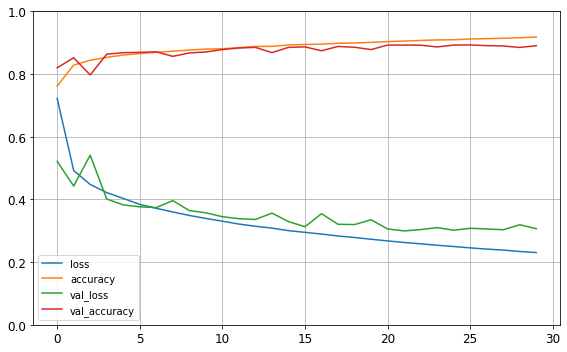

In [51]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
save_fig('keras_learning_curves_plot')
plt.show()

모델의 검증 정확도(val_accuracy)가 만족스럽다면 모델을 배포하기 전에 테스트 세트로 모델을 평가하여 **일반화 오차**를 추정해야 함. 이때 `evaluate()` 메서드를 사용함:

In [52]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3411 - accuracy: 0.8782


[0.34114891290664673, 0.8781999945640564]

### 모델을 사용해 예측을 만들기  
그다음 모델의 `predict()` 메서드를 사용해 새로운 샘플에 대해 예측을 만들 수 있음(여기서는 실제 새로운 샘플이 없기 때문에 테스트 세트의 처음 3개 샘픙르 사용하겠음):

In [53]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 101ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**주의: 책에 있는`model.predict_classes(X_new)`는 삭제될 예정**(실제로 실행해보니 없다고 오류 뜸)  
대신 `np.argmax(model.predict(X_new), axis=-1)`을 사용

In [55]:
#y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 19ms/step


array([9, 2, 1], dtype=int64)

In [56]:
# 예측한 클래스 이름 출력
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [57]:
# 실제 클래스 번호 및 이름 출력
y_new = y_test[:3]
print(y_new, np.array(class_names)[y_new])

[9 2 1] ['Ankle boot' 'Pullover' 'Trouser']


## 10.2.3 시퀀셜 API를 사용하여 회귀용 다층 퍼셉트론 만들기

**캘리포니아 주택 가격 데이터셋**으로 바꾸어 회귀 신경망으로 이를 해결해보겠음  
사이킷런의 `fetch_california_housing()` 함수를 사용해 데이터를 적재한 후 훈련, 검증, 테스트 세트로 나누고 모든 특성의 스케일을 조정:

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

### 시퀀셜 API를 사용해 회귀용 MLP를 구축, 훈련, 평가, 예측 수행  
<주된 차이점>  
- 출력층이 활성화 함수가 없는 하나의 뉴런(하나의 값을 예측하기 때문)을 가진다는 것
- 손실 함수로 '평균 제곱 오차'를 사용한다는 것

In [60]:
# 모델 구축
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

# 모델 컴파일 후 훈련
model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

# 모델 평가
mse_test = model.evaluate(X_test, y_test)

# 모델 예측
X_new = X_test[:3] # 새로운 샘플이라고 생각
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7216 - val_loss: 0.5452
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4718 - val_loss: 0.4718
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4517 - val_loss: 0.4707
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4333 - val_loss: 0.4687
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6002 - val_loss: 0.4564
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4221 - val_loss: 0.4457
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4128 - val_loss: 0.4326
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4043 - val_loss: 0.4316
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3975 - val_loss: 0.4229
Epoch 10/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3937 - val_loss: 0.4195

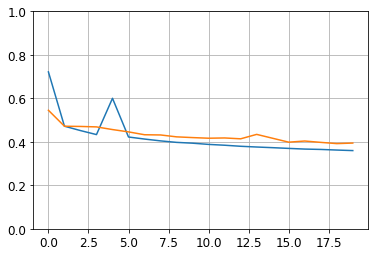

In [61]:
# train, validation 손실 그래프 출력
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [62]:
# 예측값과 실제값 비교
y_new = y_test[:3]
print(y_pred, y_new)

[[0.6486407]
 [1.6982234]
 [3.7767267]] [0.477   0.458   5.00001]


## 10.2.4 함수형 API를 사용해 복잡한 모델 만들기

모든 신경망 모델이 단순하게 **순서대로(Sequential)** 나열되지는 않음  
어떤 신경망은 여러 개의 입력이 있거나 여러 개의 출력이 있는 등 매우 복잡한 구조를 가짐  
순차적이지 않은 신경망의 한 예인 **와이드 & 딥(Wide & Deep) 신경망**을 만들어 캘리포니아 주택 문제를 해결해보겠음:

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [66]:
# 이전과 동일하게 컴파일 후 평가, 예측 수행
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8071 - val_loss: 0.7709
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6923 - val_loss: 0.6806
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6412 - val_loss: 0.6451
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6120 - val_loss: 0.6212
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5903 - val_loss: 0.5996
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5714 - val_loss: 0.5846
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5562 - val_loss: 0.5687
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5428 - val_loss: 0.5566
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5318 - val_loss: 0.5466
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5223 - val_loss: 0.5383

만약 일부 특성은 짧은 경로로 전달하고 다른 특성들은 깊은 경로로 전달하고 싶다면, 여러 입력을 이용하는 방법이 있음  
예시로 5개 특성(특성 0에서 4까지)은 짧은 경로로 보내고, 6개 특성(특성 2에서 7까지)은 깊은 경로로 보내게끔 설계해보겠음. 3개의 특성(특성 2,3,4)은 양쪽에 모두 전달됨

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 30)           930         ['dense_8[0][0]']                
                                                                                            

In [70]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                   validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8907 - val_loss: 0.9393
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8525 - val_loss: 0.7802
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7574 - val_loss: 0.7288
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7121 - val_loss: 0.6931
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6770 - val_loss: 0.6620
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6481 - val_loss: 0.6369
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6236 - val_loss: 0.6157
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6022 - val_loss: 0.5965
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5834 - val_loss: 0.5802
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5677 - val_loss: 0.5663

규제를 위한 보조 출력 추가하기:

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

주 출력과 보조 출력은 각각 자신만의 손실 함수가 필요하므로, 모델을 컴파일할 때 손실의 리스트를 전달해야 함  
또한 보조 출력보다 주 출력에 더 관심이 많다면(보조 출력은 규제로만 사용되므로), 주 출력의 손실에 더 많은 가중치를 부여해야 함:

In [73]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

모델을 훈련할 때에도 각 출력에 대한 레이블을 리스트 형태로 제공해야 함:

In [74]:
# 출력 레이블을 리스트로 전달 안해도 실행이 되기는 함
history = model.fit([X_train_A, X_train_B], y_train, epochs=20,
                   validation_data=([X_valid_A, X_valid_B], y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.9058 - main_output_loss: 2.7511 - aux_output_loss: 4.2982 - val_loss: 1.3403 - val_main_output_loss: 1.1076 - val_aux_output_loss: 3.4346
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.0502 - main_output_loss: 0.8522 - aux_output_loss: 2.8326 - val_loss: 0.9354 - val_main_output_loss: 0.7589 - val_aux_output_loss: 2.5237
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8651 - main_output_loss: 0.7146 - aux_output_loss: 2.2201 - val_loss: 0.8398 - val_main_output_loss: 0.6999 - val_aux_output_loss: 2.0992
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7967 - main_output_loss: 0.6744 - aux_output_loss: 1.8971 - val_loss: 0.7897 - val_main_output_loss: 0.6727 - val_aux_output_loss: 1.8426
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7534 - main_output_loss: 0.6488 - aux_output_loss: 1.6947 - val_loss

In [75]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                   validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5528 - main_output_loss: 0.4960 - aux_output_loss: 1.0642 - val_loss: 0.5713 - val_main_output_loss: 0.5138 - val_aux_output_loss: 1.0880
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5485 - main_output_loss: 0.4933 - aux_output_loss: 1.0457 - val_loss: 0.5663 - val_main_output_loss: 0.5102 - val_aux_output_loss: 1.0710
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5447 - main_output_loss: 0.4908 - aux_output_loss: 1.0293 - val_loss: 0.5619 - val_main_output_loss: 0.5071 - val_aux_output_loss: 1.0551
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5410 - main_output_loss: 0.4885 - aux_output_loss: 1.0139 - val_loss: 0.5596 - val_main_output_loss: 0.5065 - val_aux_output_loss: 1.0379
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5376 - main_output_loss: 0.4865 - aux_output_loss: 0.9983 - val_loss

모델을 평가하면 케라스는 개별 손실과 함께 총 손실도 반환함:

In [76]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.5082 - main_output_loss: 0.4750 - aux_output_loss: 0.8063


비슷하게 `predict()` 메서드는 각 출력에 대한 예측을 반환함:

In [77]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 75ms/step


## 10.2.5 서브클래싱 API로 동적 모델 만들기  
어떤 모델은 반복문을 포함하고 다양한 크기를 다루어야 하며 조건문을 가지는 등 여러가지 동적인 구조를 필요로 함  
이런 경우 조금 더 **명령형(imperative)** 프로그래밍 스타일인 **서브클래싱(subclassing) API**가 적합함

다음 **WideAndDeepModel** 클래스의 인스턴스는 앞서 함수형 API로 만든 모델과 동일한 기능을 수행함

In [79]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel(30, activation='relu')

이전과 동일하게 이 인스턴스를 사용해 모델 컴파일, 훈련, 평가, 예측을 수행할 수 있음:

In [80]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                   validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 2.5794 - output_1_loss: 2.2693 - output_2_loss: 5.3707 - val_loss: 1.3960 - val_output_1_loss: 1.0699 - val_output_2_loss: 4.3308
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 1.1524 - output_1_loss: 0.8960 - output_2_loss: 3.4604 - val_loss: 0.9433 - val_output_1_loss: 0.7353 - val_output_2_loss: 2.8156
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8617 - output_1_loss: 0.6998 - output_2_loss: 2.3195 - val_loss: 0.7926 - val_output_1_loss: 0.6507 - val_output_2_loss: 2.0699
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7464 - output_1_loss: 0.6323 - output_2_loss: 1.7734 - val_loss: 0.7237 - val_output_1_loss: 0.6130 - val_output_2_loss: 1.7197
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6876 - output_1_loss: 0.5951 - output_2_loss: 1.5205 - val_loss: 0.6820 - val_output_1_loss: 0.5864 - val_ou

## 10.2.6 모델 저장과 복원  
**시퀀셜 API와 함수형 API**를 사용하면 **훈련된 케라스 모델을 저장하는 것**은 매우 쉬움  
일단 다시 **시퀀셜 API**를 사용하여 모델을 빠르게 훈련시키겠음

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

In [83]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [84]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.4250 - val_loss: 0.9795
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7676 - val_loss: 0.6374
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6271 - val_loss: 0.5982
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5902 - val_loss: 0.5793
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5719 - val_loss: 0.5629
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5554 - val_loss: 0.5538
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5428 - val_loss: 0.5394
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5306 - val_loss: 0.5311
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5206 - val_loss: 0.5213
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.5217


케라스는 **HDF5** 포맷을 사용하여 (모든 층의 하이퍼파라미터를 포함하여) **모델 구조와 모든 모델의 파라미터(즉, 연결 가중치와 편향), 옵티마이저**를 저장함  
모델 저장 시에는 `save()` 메서드를 사용함:

In [85]:
model.save('my_keras_model.h5')

모델 로드 시에는 `load_model()` 메서드를 사용함:

In [8]:
model = keras.models.load_model('my_keras_model.h5')

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_new = X_test[:3]

In [17]:
model.predict(X_new)

1/1 [==============================] - 0s 35ms/step


array([[0.52478504],
       [1.5008252 ],
       [4.4773912 ]], dtype=float32)

모델의 가중치만 따로 저장하려면 다음과 같이 `save_weights()` 메서드를 사용함:

In [88]:
model.save_weights('my_keras_weights.ckpt')

저장한 가중치를 로드할 때는 다음과 같이 `load_weights()` 메서드를 사용함:

In [89]:
model.load_weights('my_keras_weights.ckpt')

하지만 대규모 데이터셋에서 훈련 시 훈련이 몇 시간 동안 지속되는 경우가 많음  
이럴 경우 컴퓨터에 문제가 생겨 모든 것을 잃지 않으려면 훈련 마지막에 모델을 저장하는 것뿐만 아니라 **훈련 도중 일정 간격으로 체크포인트(checkpoint)를 저장**해야 함  

이때 사용하는 것이 바로 **콜백(callback)**

## 10.2.7 콜백 사용하기

`fit()` 메서드의 `callbacks` 매개변수를 사용하여 케라스가 훈련의 시작이나 끝에 호출할 객체 리스트를 지정할 수 있음. 또는 에포크의 시작이나 끝, 각 배치 처리 전후에 호출할 수도 있음  

In [91]:
# 다시 케라스의 백엔드를 초기화하고 시퀀셜 API로 모델 구축, 컴파일
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

예를 들어 **ModelCheckpoint**는 훈련하는 동안 일정 간격으로 모델의 체크포인트를 저장함(기본적으로 매 에포크의 끝에서 호출됨)  
훈련하는 동안 검증 세트를 사용하면 ModelCheckpoint를 만들 때 `save_best_only=True`로 지정할 수 있음. 이렇게 하면 최상의 검증 세트 점수에서만 모델을 저장함  
이러면 오랜 훈련 시간으로 훈련 세트에 과대적합될 걱정을 하지 안항도 되며, 훈련이 끝난 후 마지막에 저장된 모델만 복원하면 됨  

다음 코드는 **조기 종료**를 구현하는 방법임:

In [92]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', 
                                               save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb])

model = keras.models.load_model('my_keras_model.h5') # 최상의 모델로 복원
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.6893 - val_loss: 0.8090
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7302 - val_loss: 0.6904
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6630 - val_loss: 0.6450
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6182 - val_loss: 0.6113
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5892 - val_loss: 0.5839
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5627 - val_loss: 0.5638
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5416 - val_loss: 0.5469
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5245 - val_loss: 0.5322
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5106 - val_loss: 0.5214
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.5068


조기 종료를 구현하는 또다른 방법은 **EarlyStopping** 콜백을 사용하는 것임  
이 콜백은 일정 에포크(`patience` 매개변수로 지정) 동안 검증 세트에 대한 점수가 향상되지 않으면 훈련을 멈추는 기능을 함  

다음과 같이 *체크포인트 저장 콜백*과 *진전이 없는 경우 훈련을 일찍 멈추는 콜백*을 함께 사용할 수도 있음: 

In [93]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                 restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4899 - val_loss: 0.5059
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4830 - val_loss: 0.4981
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4760 - val_loss: 0.4931
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4698 - val_loss: 0.4895
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4670 - val_loss: 0.4845
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4614 - val_loss: 0.4818
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4782
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4542 - val_loss: 0.4750
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4510 - val_loss: 0.4728
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4490 - val_lo

더 많은 제어를 원하면 **사용자 정의 콜백**을 만들 수 있음  

다음과 같은 사용자 정의 콜백은 훈련하는 동안 검증 손실과 훈련 손실의 비율을 출력함(즉 과대적합을 방지함):

In [94]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('\nval/train: {:.2f}'.format(logs['val_loss'] / logs['loss']))

In [95]:
val_train_ratio_cb = PrintValTrainRatioCallback()

history = model.fit(X_train, y_train, epochs=3,
                   validation_data=(X_valid, y_valid),
                   callbacks=[val_train_ratio_cb])

Epoch 1/3
355/363 [============================>.] - ETA: 0s - loss: 0.3591
val/train: 1.11
363/363 [==============================] - 1s 2ms/step - loss: 0.3597 - val_loss: 0.3976
Epoch 2/3
357/363 [============================>.] - ETA: 0s - loss: 0.3595
val/train: 1.11
363/363 [==============================] - 1s 2ms/step - loss: 0.3585 - val_loss: 0.3964
Epoch 3/3
361/363 [============================>.] - ETA: 0s - loss: 0.3593
val/train: 1.10
363/363 [==============================] - 1s 2ms/step - loss: 0.3590 - val_loss: 0.3956


이제 **tf.keras**를 사용할 때 반드시 알아야 할 도구인 **텐서보드(TensorBoard)**를 알아보겠음

## 10.2.8 텐서보드를 사용해 시각화하기  
텐서보드는 매우 좋은 인터렉티브 시각화 도구임  

먼저 텐서보드 로그를 위해 사용할 루트 로그 디렉터리를 정의하겠음  
그리고 현재 날짜와 시간을 사용해 실행할 때마다 다른 서브디렉터리 경로를 생성하는 간단한 함수도 만들겠음  
테스트하는 하이퍼파라미터 값과 같은 추가적인 정보를 로그 디렉터리 이름으로 사용할 수 있음  
이렇게 하면 텐서보드에서 어떤 로그인지 구분하기 편리함

In [96]:
import os
root_logdir = os.path.join(os.curdir, 'my_logs')

In [97]:
def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_09_15-13_46_57'

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

텐서보드는 다음과 같이 케라스의 `TensorBoard()`로 사용할 수 있음

In [100]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 3ms/step - loss: 2.0601 - val_loss: 0.9373
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.7950 - val_loss: 0.7297
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.7004 - val_loss: 0.6786
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6520 - val_loss: 0.6421
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6158 - val_loss: 0.6098
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5845 - val_loss: 0.5826
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5593 - val_loss: 0.5604
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5381 - val_loss: 0.5427
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5216 - val_loss: 0.5280
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5087 - val_loss: 0.5164

다음 명령을 실행하여 주피터 안에서 바로 텐서보드를 사용할 수 있음  
첫 번째 라인은 텐서보드 확장을 로드함  
두 번째 라인은 (이미 실행 중이 아니라면) 포트 6006에서 텐서보드 서버를 실행하고 접속함

In [101]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

텐서보드에서 2개의 실행을 비교해보기 위해 모델을 하나 더 만듦

In [102]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2022_09_15-13_55_49'

In [103]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [105]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.7019 - val_loss: 3.6475
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6183 - val_loss: 0.4308
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4007 - val_loss: 0.4143
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3838 - val_loss: 0.3894
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3719 - val_loss: 0.3970
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3648 - val_loss: 0.3868
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3592 - val_loss: 0.3606
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3437 - val_loss: 0.4011
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3386 - val_loss: 0.3695
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3377 - val_loss: 0.3818

다시 텐서보드 실행

In [106]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9188), started 0:03:17 ago. (Use '!kill 9188' to kill it.)

In [107]:
%reload_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 9188), started 0:03:45 ago. (Use '!kill 9188' to kill it.)

텐서플로는 `tf.summary` 패키지로 저수준 API를 제공함  

다음 코드는 `create_file_writer()` 함수를 사용해 **SummaryWriter**를 만들고 **with** 블럭 안에서 텐서보드를 사용해 시각화할 수 있는 스칼라, 히스토그램, 이미지, 오디오, 텍스트를 기록함: 

In [108]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000+1):
        tf.summary.scalar('my_scalar', np.sin(step/10), step=step)
        data = (np.random.randn(100)+2) * step / 100 # 몇몇 랜덤 데이터
        tf.summary.histogram('my_hist', data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # 32x32 RGB 이미지
        tf.summary.image('my_images', images * step / 1000, step=step)
        texts = ['The step is ' + str(step), "Its square is " + str(step**2)]
        tf.summary.text('my_text', texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio('my_audio', audio, sample_rate=48000, step=step)

In [110]:
%reload_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 9188), started 3:18:13 ago. (Use '!kill 9188' to kill it.)

# 10.3 신경망 하이퍼파라미터 튜닝하기

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

어떤 하이퍼파라미터 조합이 주어진 문제에 최적인지 알아내는 방법은 많은 조합을 시도해보고 어떤 것이 검증 세트에서 가장 좋은 점수를 내는지 확인하는 방법이 있음  

이렇게 하려면 케라스 모델을 사이킷런 추정기처럼 보이도록 바꾸어야 함  
먼저 일련의 하이퍼파라미터로 케라스 모델을 만들고 컴파일하는 함수를 만듦:

In [19]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

`build_model()` 함수를 사용해 KerasRegressor 클래스의 객체를 만듦:

In [21]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\seculayer\AppData\Local\Temp\ipykernel_5904\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


모델 훈련, 평가, 예측 진행:

In [22]:
keras_reg.fit(X_train, y_train, epochs=100,
             validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 2.0408 - val_loss: 0.9322
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.8026 - val_loss: 0.7071
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6677 - val_loss: 0.6581
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6241 - val_loss: 0.6258
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5964 - val_loss: 0.5997
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5722 - val_loss: 0.5794
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5529 - val_loss: 0.5603
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5359 - val_loss: 0.5451
Epoch 9/100
363/363 [==============================] - 1s 1ms/step - loss: 0.5220 - val_loss: 0.5326
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5102 - val_lo

363/363 [==============================] - 1s 2ms/step - loss: 0.3915 - val_loss: 0.4175
Epoch 82/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3917 - val_loss: 0.4184
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3907 - val_loss: 0.4173
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3903 - val_loss: 0.4165
Epoch 85/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3897 - val_loss: 0.4170
Epoch 86/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3892 - val_loss: 0.4154
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3884 - val_loss: 0.4148
Epoch 88/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3883 - val_loss: 0.4137
Epoch 89/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3872 - val_loss: 0.4166
Epoch 90/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3879 - val_loss: 

In [23]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3895


In [24]:
y_pred = keras_reg.predict(X_new)

1/1 [==============================] - 0s 58ms/step


모델 하나를 훈련하고 평가하려는 것이 아니라 수백 개의 모델을 훈련하고 검증 세트에서 최상의 모델을 선택해야 함. 이 경우 하이퍼파라미터가 많으므로 그리드 탐색보다 **랜덤 탐색**을 사용하는 것이 좋음  

은닉층 개수, 뉴런 개수, 학습률을 사용해 하이퍼파라미터 탐색을 수행:

**경고**: 다음 셀은 훈련이 끝날 때 에러가 납니다. 이는 최근 사이킷런의 변화때문에 생긴 케라스 이슈 #13586 때문입니다. 이 이슈를 해결하기 위한 풀 리퀘스트 #13598가 있으므로 곧 해결될 것 같습니다. 그때까지는 `.tolist()`와 `rvs(1000).tolist()`를 추가해 사용합니다.

In [26]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden': [0,1,2,3],
    'n_neurons': np.arange(1,100).tolist(),
    'learning_rate': reciprocal(3e-4, 3e-2).rvs(1000).tolist()
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                 validation_data=(X_valid, y_valid),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.0448 - val_loss: 0.6736
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5997 - val_loss: 0.5662
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5202 - val_loss: 0.5063
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4751 - val_loss: 0.4796
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4528 - val_loss: 0.4643
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4369 - val_loss: 0.4493
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4259 - val_loss: 0.4415
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4163 - val_loss: 0.4424
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4099 - val_loss: 0.4274
Epoch 10/100
242/242 [========

Epoch 81/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2755 - val_loss: 0.3311
Epoch 82/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2744 - val_loss: 0.3237
Epoch 83/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2742 - val_loss: 0.3278
Epoch 84/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2724 - val_loss: 0.3537
Epoch 85/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2734 - val_loss: 0.3197
Epoch 86/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2721 - val_loss: 0.3299
Epoch 87/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2716 - val_loss: 0.3343
Epoch 88/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2741 - val_loss: 0.3249
Epoch 89/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2704 - val_loss: 0.3346
Epoch 90/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2699

Epoch 65/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2945 - val_loss: 0.3457
Epoch 66/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2908 - val_loss: 0.3474
Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2906 - val_loss: 0.3387
Epoch 68/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2914 - val_loss: 0.3437
Epoch 69/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2890 - val_loss: 0.3462
Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2887 - val_loss: 0.3405
Epoch 71/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2873 - val_loss: 0.3382
Epoch 72/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2858 - val_loss: 0.3523
Epoch 73/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2867 - val_loss: 0.3377
Epoch 74/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2854

Epoch 55/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2954 - val_loss: 0.3465
Epoch 56/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2948 - val_loss: 0.3433
Epoch 57/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2924 - val_loss: 0.3457
Epoch 58/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2945 - val_loss: 0.3382
Epoch 59/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2927 - val_loss: 0.3401
Epoch 60/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2906 - val_loss: 0.3500
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2922 - val_loss: 0.3382
Epoch 62/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2887 - val_loss: 0.3446
Epoch 63/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2907 - val_loss: 0.3443
Epoch 64/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2895

Epoch 34/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3654 - val_loss: 0.3941
Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3598 - val_loss: 0.4097
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3564 - val_loss: 0.4070
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3557 - val_loss: 0.3903
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3571 - val_loss: 0.3887
Epoch 39/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3533 - val_loss: 0.3879
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3511 - val_loss: 0.3891
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3500 - val_loss: 0.3863
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3632 - val_loss: 0.3832
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3475

Epoch 54/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3262 - val_loss: 0.3785
Epoch 55/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3304 - val_loss: 0.3698
Epoch 56/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3252 - val_loss: 0.7190
Epoch 57/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3525 - val_loss: 0.3745
Epoch 58/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3231 - val_loss: 0.3914
Epoch 59/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3237 - val_loss: 0.3770
Epoch 60/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3296 - val_loss: 0.3810
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3253 - val_loss: 0.3711
Epoch 62/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3219 - val_loss: 0.3784
Epoch 63/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3218

242/242 [==============================] - 0s 2ms/step - loss: 0.6755 - val_loss: 0.7025
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6595 - val_loss: 0.6853
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6450 - val_loss: 0.6695
Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6321 - val_loss: 0.6552
Epoch 15/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6201 - val_loss: 0.6424
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6092 - val_loss: 0.6307
Epoch 17/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5991 - val_loss: 0.6195
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5899 - val_loss: 0.6096
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5813 - val_loss: 0.6012
Epoch 20/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5735 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.4275 - val_loss: 0.4500
Epoch 92/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4268 - val_loss: 0.4489
Epoch 93/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4262 - val_loss: 0.4487
Epoch 94/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4255 - val_loss: 0.4478
Epoch 95/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4249 - val_loss: 0.4473
Epoch 96/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4243 - val_loss: 0.4466
Epoch 97/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4236 - val_loss: 0.4463
Epoch 98/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4231 - val_loss: 0.4459
Epoch 99/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4225 - val_loss: 0.4452
Epoch 100/100
121/121 [==============================] - 0s 1ms/step - loss: 0.4274
[CV] END le

Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4263 - val_loss: 0.4582
Epoch 71/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4255 - val_loss: 0.4576
Epoch 72/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4247 - val_loss: 0.4568
Epoch 73/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4240 - val_loss: 0.4559
Epoch 74/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4232 - val_loss: 0.4553
Epoch 75/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4224 - val_loss: 0.4546
Epoch 76/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4217 - val_loss: 0.4538
Epoch 77/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4210 - val_loss: 0.4532
Epoch 78/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4203 - val_loss: 0.4527
Epoch 79/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4196

Epoch 49/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4901 - val_loss: 0.4974
Epoch 50/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4881 - val_loss: 0.4957
Epoch 51/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4861 - val_loss: 0.4940
Epoch 52/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4842 - val_loss: 0.4924
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4821 - val_loss: 0.4905
Epoch 54/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4805 - val_loss: 0.4890
Epoch 55/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4786 - val_loss: 0.4876
Epoch 56/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4769 - val_loss: 0.4860
Epoch 57/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4752 - val_loss: 0.4850
Epoch 58/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4737

Epoch 28/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3177 - val_loss: 0.3686
Epoch 29/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3182 - val_loss: 0.3594
Epoch 30/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3125 - val_loss: 0.3613
Epoch 31/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3131 - val_loss: 0.3727
Epoch 32/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3109 - val_loss: 0.3600
Epoch 33/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3113 - val_loss: 0.3531
Epoch 34/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3055 - val_loss: 0.3573
Epoch 35/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3041 - val_loss: 0.3543
Epoch 36/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3051 - val_loss: 0.3618
Epoch 37/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3035

Epoch 32/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3052 - val_loss: 0.3467
Epoch 33/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3036 - val_loss: 0.3537
Epoch 34/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3032 - val_loss: 0.3428
Epoch 35/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2993 - val_loss: 0.3434
Epoch 36/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3007 - val_loss: 0.3434
Epoch 37/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2943 - val_loss: 0.3527
Epoch 38/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2977 - val_loss: 0.3389
Epoch 39/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2947 - val_loss: 0.3423
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2926 - val_loss: 0.3394
Epoch 41/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2896

Epoch 40/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3318 - val_loss: 0.3777
Epoch 41/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3310 - val_loss: 0.3680
Epoch 42/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3293 - val_loss: 0.3691
Epoch 43/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3273 - val_loss: 0.3659
Epoch 44/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3259 - val_loss: 0.3639
Epoch 45/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3248 - val_loss: 0.3637
Epoch 46/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3226 - val_loss: 0.3657
Epoch 47/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3211 - val_loss: 0.3602
Epoch 48/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3200 - val_loss: 0.3618
Epoch 49/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3182

Epoch 19/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3719 - val_loss: 0.4122
Epoch 20/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3698 - val_loss: 0.4097
Epoch 21/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3663 - val_loss: 0.4055
Epoch 22/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3638 - val_loss: 0.4100
Epoch 23/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3669 - val_loss: 0.4091
Epoch 24/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3722 - val_loss: 0.4047
Epoch 25/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3568 - val_loss: 0.3987
Epoch 26/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3547 - val_loss: 0.4054
Epoch 27/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3509 - val_loss: 0.3944
Epoch 28/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3491

Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4316 - val_loss: 0.4458
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4237 - val_loss: 0.4412
Epoch 11/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4187 - val_loss: 0.4356
Epoch 12/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4138 - val_loss: 0.4336
Epoch 13/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4080 - val_loss: 0.4269
Epoch 14/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4043 - val_loss: 0.4266
Epoch 15/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4002 - val_loss: 0.4294
Epoch 16/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3967 - val_loss: 0.4177
Epoch 17/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3933 - val_loss: 0.4178
Epoch 18/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3884 

242/242 [==============================] - 1s 2ms/step - loss: 0.2850 - val_loss: 0.3447
Epoch 90/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2857 - val_loss: 0.3394
Epoch 91/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2841 - val_loss: 0.3374
Epoch 92/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2834 - val_loss: 0.3474
Epoch 93/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2828 - val_loss: 0.3393
Epoch 94/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2827 - val_loss: 0.3339
Epoch 95/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2804 - val_loss: 0.3300
Epoch 96/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2804 - val_loss: 0.3324
Epoch 97/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2787 - val_loss: 0.3330
Epoch 98/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2792 - val_loss: 

121/121 [==============================] - 0s 1ms/step - loss: nan
[CV] END learning_rate=0.02835909027838403, n_hidden=1, n_neurons=28; total time=   5.6s
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.9146 - val_loss: 5.2905
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: nan

242/242 [==============================] - 0s 2ms/step - loss: 0.3007 - val_loss: 0.3740
Epoch 31/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3006 - val_loss: 0.3543
Epoch 32/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3006 - val_loss: 0.3370
Epoch 33/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2995 - val_loss: 0.3513
Epoch 34/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2985 - val_loss: 0.3355
Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2959 - val_loss: 0.3320
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2968 - val_loss: 0.3416
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2882 - val_loss: 0.3463
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2911 - val_loss: 0.3317
Epoch 39/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2917 - val_loss: 

Epoch 48/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2869 - val_loss: 0.3338
Epoch 49/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2856 - val_loss: 0.3230
Epoch 50/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2866 - val_loss: 0.3136
Epoch 51/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2818 - val_loss: 0.3181
Epoch 52/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2847 - val_loss: 0.3214
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2833 - val_loss: 0.3161
Epoch 54/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2831 - val_loss: 0.3242
Epoch 55/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2810 - val_loss: 0.3271
Epoch 56/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2813 - val_loss: 0.3316
Epoch 57/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2789

Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2395 - val_loss: 0.3284
Epoch 68/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.3242
Epoch 69/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2434 - val_loss: 0.2978
Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2389 - val_loss: 0.3002
Epoch 71/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2383 - val_loss: 0.3092
Epoch 72/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2375 - val_loss: 0.3132
Epoch 73/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2351 - val_loss: 0.3277
Epoch 74/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2357 - val_loss: 0.2915
Epoch 75/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2339 - val_loss: 0.3269
Epoch 76/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2339

Epoch 11/100
121/121 [==============================] - 0s 1ms/step - loss: nan
[CV] END learning_rate=0.02681276837118844, n_hidden=3, n_neurons=68; total time=   6.1s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.1003 - val_loss: 0.6979
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6337 - val_loss: 0.6061
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5672 - val_loss: 0.5530
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5236 - val_loss: 0.5205
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4973 - val_loss: 0.5007
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4758 - val_loss: 0.4829
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4600 - val_loss: 0.4710
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4463 - val_loss: 0.4596
Epoch 9/100
242/242 [==

Epoch 79/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3047 - val_loss: 0.3455
Epoch 80/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3053 - val_loss: 0.3429
Epoch 81/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3046 - val_loss: 0.3405
Epoch 82/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3036 - val_loss: 0.3455
Epoch 83/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3029 - val_loss: 0.3482
Epoch 84/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3022 - val_loss: 0.3509
Epoch 85/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3022 - val_loss: 0.3376
Epoch 86/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3006 - val_loss: 0.3405
Epoch 87/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3013 - val_loss: 0.3416
Epoch 88/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3021

Epoch 58/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3207 - val_loss: 0.3744
Epoch 59/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3201 - val_loss: 0.3720
Epoch 60/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3185 - val_loss: 0.3704
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3183 - val_loss: 0.3704
Epoch 62/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3183 - val_loss: 0.3753
Epoch 63/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3210 - val_loss: 0.3674
Epoch 64/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3152 - val_loss: 0.3773
Epoch 65/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3194 - val_loss: 0.3660
Epoch 66/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3143 - val_loss: 0.3690
Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3147

Epoch 48/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3341 - val_loss: 0.3804
Epoch 49/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3329 - val_loss: 0.3772
Epoch 50/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3329 - val_loss: 0.3741
Epoch 51/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3312 - val_loss: 0.3759
Epoch 52/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3328 - val_loss: 0.3774
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3318 - val_loss: 0.3769
Epoch 54/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3363 - val_loss: 0.3825
Epoch 55/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3362 - val_loss: 0.3866
Epoch 56/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3374 - val_loss: 0.3749
Epoch 57/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3296

Epoch 38/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2702 - val_loss: 0.3258
Epoch 39/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2668 - val_loss: 0.3111
Epoch 40/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2664 - val_loss: 0.3180
Epoch 41/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2644 - val_loss: 0.3198
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2643 - val_loss: 0.3094
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2675 - val_loss: 0.3097
Epoch 44/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2638 - val_loss: 0.3777
Epoch 45/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2636 - val_loss: 0.3137
Epoch 46/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2626 - val_loss: 0.3118
Epoch 47/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2604

Epoch 59/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2577 - val_loss: 0.3259
Epoch 60/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2528 - val_loss: 0.3050
Epoch 61/100
121/121 [==============================] - 0s 1ms/step - loss: 0.2939
[CV] END learning_rate=0.021452449765836837, n_hidden=3, n_neurons=75; total time=  32.3s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6777 - val_loss: 0.5507
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6697 - val_loss: 0.6102
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6150 - val_loss: 0.5017
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============

C:\Users\seculayer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.31638233 -0.34349229 -0.4308027          nan -0.30816011         nan
 -0.31359047         nan -0.32806781         nan]
  warnings.warn(


363/363 [==============================] - 1s 2ms/step - loss: 1.0874 - val_loss: 0.6373
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5912 - val_loss: 0.5482
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5096 - val_loss: 0.4999
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4679 - val_loss: 0.4731
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4411 - val_loss: 0.4515
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4232 - val_loss: 0.4380
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4109 - val_loss: 0.4284
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4013 - val_loss: 0.4231
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3940 - val_loss: 0.4174
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3899 - val_loss: 0.4134
E

363/363 [==============================] - 1s 2ms/step - loss: 0.2754 - val_loss: 0.3238
Epoch 82/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2772 - val_loss: 0.3314
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2756 - val_loss: 0.3316
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2751 - val_loss: 0.3192
Epoch 85/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2730 - val_loss: 0.3415
Epoch 86/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2727 - val_loss: 0.3263
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2720 - val_loss: 0.3213
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2727 - val_loss: 0.3259
Epoch 89/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2711 - val_loss: 0.3256
Epoch 90/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2721 - val_loss: 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000018F01536610>,
                   param_distributions={'learning_rate': [0.0007036992892745927,
                                                          0.003638506452865738,
                                                          0.01671140353898045,
                                                          0.008741199405528767,
                                                          0.012309588936393927,
                                                          0.006232868841909281,
                                                          0.0072723434950311555,
                                                          0.014980025679402079,
                                                          0.000947233987395861,
                                                          0.002857400931720...
                                                          0.00035076254

실행이 끝나면 아래와 같이 랜덤 탐색이 찾은 최상의 하이퍼파라미터와 훈련된 케라스 모델을 얻을 수 있음:

In [27]:
# 최상의 하이퍼파라미터 조합
rnd_search_cv.best_params_

{'n_neurons': 83, 'n_hidden': 3, 'learning_rate': 0.0028951893171465437}

In [28]:
# 제일 좋았던 score
rnd_search_cv.best_score_

-0.3081601063410441

In [29]:
# 테스트 세트에 평가
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3012


-0.3012039065361023

이제 이 모델을 저장하고 테스트 세트에서 평가:

In [30]:
model = rnd_search_cv.best_estimator_.model
model

In [31]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3012


0.3012039065361023

<정리>  
하이퍼파라미터 값의 범위를 크게 하여 빠르게 첫번째 랜덤 탐색을 수행하고, 첫번째 탐색에서 찾은 최상의 하이퍼파라미터 값을 중심으로 계속해서 더 좁은 범위를 탐색하는 방식으로 진행하면 좋은 하이퍼파라미터 집합을 좁혀 나갈 수 있음

# 10.4 연습문제

- 연습문제1: https://playground.tensorflow.org 사이트에서 직접 실험  
- 연습문제2: 직접 손으로 그려봄
- 연습문제3: 고전적인 퍼셉트론의 계단 함수는 수평선밖에 없어 계산할 그레이디언트가 없지만, 로지스틱 함수는 어디서든지 0이 아닌 그레이디언트가 잘 정의되어 있기 때문에 역전파 알고리즘을 사용하기 위해 로지스틱 회귀 분류기를 일반적으로 선호한다. 퍼셉트론의 계단 함수로 로지스틱 함수를 사용하면 로지스틱 회귀 분류기와 동등하게 만들 수 있다.  
- 연습문제4: 로지스틱 활성화 함수는 도함수가 어디에서나 0이 아니므로 경사 하강법에 의해 항상 이동할 수 있기 때문에 초창기 다중 퍼셉트론의 훈련의 핵심 요소였다. 계단 함수를 활성화 함수로 사용하면 경사 하강법을 사용할 수 없기 때문에 로지스틱 활성화 함수를 사용하는 것이 핵심이었다고 볼 수 있다.
- 연습문제5: 로지스틱(시그모이드) 함수, 쌍곡 탄젠트(tanh) 함수, ReLU 함수
- 연습문제6-1: 입력 행렬 X의 크기는 "(훈련 배치의 크기)x10" 이다.
- 연습문제6-2: 은닉층의 가중치 행렬 W_h의 크기는 "10x50", 편향 벡터 b_h의 길이는 50이다.
- 연습문제6-3: 출력층의 가중치 행렬 W_o의 크기는 "50x3", 편향 벡터 b_o의 길이는 3이다.
- 연습문제6-4: 네트워크 출력 행렬 Y의 크기는 "(훈련 배치의 크기)x3" 이다. **(처음과 끝)**
- 연습문제6-5: **Y = ReLU(ReLU(X x W_h + b_h) x W_o + b_o)** -> 처음 풀 때 ReLU 적용하는 것을 빠트림
- 연습문제7: 스팸 메일 분류의 출력층에 필요한 뉴런 개수: 1(이진 분류이므로) & 사용해야 할 활성화 함수: 시그모이드 함수 / MNIST 문제의 출력층에 필요한 뉴런 개수: ~9~10(종류가 10개이므로) & 사용해야 할 활성화 함수: 소프트맥스 함수 / 2장에서의 주택 가격을 예측하는 신경망을 만들고 싶다면 출력층에 **활성화 함수가 없는 출력 뉴런 하나가 필요(답 몰랐음)**  
- 연습문제8: 역전파는 모델의 모든 파라미터에 대한 비용 함수의 그래디언트를 계산하고, 이 그래디언트를 사용해 경사 하강법 스텝을 수행하는 식으로 인공 신경망을 훈련시키는 기법이다. / 역전파는 그래디언트 계산과 경사 하강법 스텝을 여러 번 수행하여 인공 신경망을 훈련시키는 **전체 프로세스**를 의미하는 반면, 후진 모드 자동 미분은 그래디언트를 효과적으로 계산하는, **역전파에서 사용되는 하나의 기법**이다.
- 연습문제9: 다층 퍼셉트론에서 조절할 수 있는 파라미터: **은닉층 수, 각 은닉층의 뉴런 수, 각 은닉층과 출력층에서 사용하는 활성화 함수** / 다층 퍼셉트론이 과대적합되었다면 은닉층 수와 각 은닉층에 있는 뉴런 수를 **줄여볼 수 있다.**

### 연습문제 10.  
문제: 심층 MLP를 MNIST 데이터셋에 훈련해보세요(`keras.datasets.mnist.load_data()` 함수를 사용해 데이터를 적재할 수 있습니다). 98% 이상의 정확도를 얻을 수 있는지 확인해보세요. 이 장에서 소개한 방법을 사용해 최적의 학습률을 찾아보세요(즉 학습률을 지수적으로 증가시키면서 손실을 그래프로 그립니다. 그다음 손실이 다시 증가하는 지점을 찾습니다). 모든 부가 기능을 추가해보세요. 즉, 체크포인트를 저장하고, 조기 종료를 사용하고, 텐서보드를 사용해 학습 곡선을 그려보세요.

In [32]:
# 데이터셋 적재
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [33]:
X_train_full.shape

(60000, 28, 28)

In [35]:
X_train_full.dtype

dtype('uint8')

In [36]:
# 훈련 세트와 검증 세트 분리 후 255로 나누어 0~1 사이의 실수로 범위 변환
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

matplotlib의 `imshow()`함수와 `binary`컬러 맵으로 이미지를 출력:

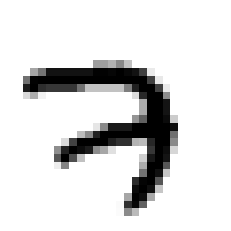

In [37]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [38]:
# 레이블과 클래스 아이디가 동일하므로 따로 class_names 배열 만들 필요 없음
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [39]:
X_valid.shape

(5000, 28, 28)

In [40]:
X_test.shape

(10000, 28, 28)

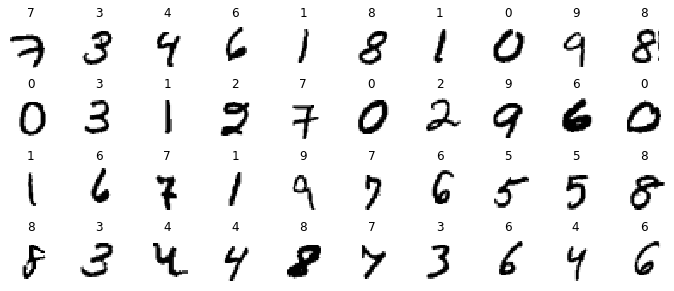

In [41]:
# 데이터셋에 있는 이미지 샘플 몇 개를 출력
n_rows=4
n_cols=10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row+col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [42]:
# 간단한 밀집 신경망을 만들고 최적의 학습률 찾기
# 반복마다 학습률을 증가시키기 위해 콜백 사용: 반복마다 학습률과 손실을 기록
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [43]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [45]:
# 작은 학습률 1e-3에서 시작하여 반복마다 0.5%씩 학습률을 증가시킴
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=1e-3), 
             metrics=['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

In [46]:
# 모델을 1 에포크만 훈련
history = model.fit(X_train, y_train, epochs=1,
                   validation_data=(X_valid, y_valid),
                   callbacks=[expon_lr])

1719/1719 [==============================] - 10s 5ms/step - loss: nan - accuracy: 0.6246 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

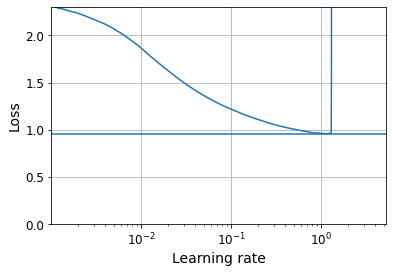

In [47]:
# 학습률에 대한 함수로 손실 그래프 그려보기
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel('Learning rate')
plt.ylabel('Loss')

<그래프 해석>  
학습률이 6e-1을 지날 때 **손실이 갑자기 솟구치기 때문에** 절반인 3e-1을 학습률로 사용하는 것이 좋다.

In [48]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [50]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [51]:
run_index = 1 # 실행할 때마다 이 값을 증가시킴
run_logdir = os.path.join(os.curdir, 'my_mnist_logs', 'run_{:03d}'.format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [52]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_mnist_model.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid), 
                   callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2316 - accuracy: 0.9273 - val_loss: 0.1089 - val_accuracy: 0.9694
Epoch 2/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0926 - accuracy: 0.9716 - val_loss: 0.1002 - val_accuracy: 0.9698
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0651 - accuracy: 0.9797 - val_loss: 0.0808 - val_accuracy: 0.9754
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0480 - accuracy: 0.9847 - val_loss: 0.0864 - val_accuracy: 0.9764
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0351 - accuracy: 0.9884 - val_loss: 0.0772 - val_accuracy: 0.9814
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0279 - accuracy: 0.9908 - val_loss: 0.0724 - val_accuracy: 0.9824
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0869 - val_ac

In [53]:
model = keras.models.load_model('my_mnist_model.h5') # 가장 좋았던 모델로 롤백
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0728 - accuracy: 0.9777


[0.07276991754770279, 0.9776999950408936]

약 97.7%의 정확도를 얻었음  
끝으로 텐서보드를 사용해 학습 곡선을 살펴보겠음:

In [55]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6007

# END